In [21]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import sklearn.svm as svm
import sklearn.neighbors as nn
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import random

def load_data(data_dir):
    # Define the image size for preprocessing
    img_size = (200, 200)
    genders = ['men', 'Women']
    # Define the label names and corresponding integer values
    label_names = ['0', '1', '2', '3', '4', '5']
    label_dict = {label_names[i]: i for i in range(len(label_names))}

    # Initialize empty lists for the images and labels
    images = []
    labels = []

    # Loop over the gender folders
    for gender in genders:
        gender_dir = os.path.join(data_dir, gender)
        # Loop over the label names
        for label_name in label_names:
            # Get the path to the label folder
            label_dir = os.path.join(gender_dir, label_name)
            # Loop over the images in the label folder
            for file_name in os.listdir(label_dir):
                # Get the path to the image file
                file_path = os.path.join(label_dir, file_name)
                # Load the image file and preprocess it
                img = cv2.imread(file_path)
                if img is None:
                    continue
                # img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img_resized = cv2.resize(img, img_size)
                img_normalized = img_resized / 255.0
                # Append the preprocessed image and corresponding label to the lists
                images.append(img_normalized)
                labels.append(label_dict[label_name])

    # Convert the image and label lists to numpy arrays
    X_train = np.array(images)
    y_train = np.array(labels)
    
    return X_train, y_train


In [22]:
def remove_shadows(image):
    # convert to LAB color space
    # print('image', image.dtype)
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
        

    # split the LAB channels
    l, a, b = cv2.split(lab)
    
    # apply the Retinex algorithm to the L channel
    # set the gain to 128 for best results
    l = cv2.createCLAHE(clipLimit=1, tileGridSize=(3,3)).apply(l)
    # merge the LAB channels back together
    lab = cv2.merge((l,a,b))

    # convert back to BGR color space
    result = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
    return result

In [75]:
def preprocess_images_thresh(images):
    X_processed = []
    light_skin = np.array([8, 50, 50],np.uint8)
    dark_skin = np.array([50, 255, 255],np.uint8)
    
    for i in range(len(images)):
        img = images[i]
        img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
        blur_img = cv2.GaussianBlur(img,(5,5),0)
        denoised_img = cv2.fastNlMeansDenoisingColored(blur_img,None,3,3,7,21)
        hsv_img = cv2.cvtColor(denoised_img,cv2.COLOR_BGR2HSV)
        frame_threshed = cv2.inRange(hsv_img, light_skin, dark_skin)
        X_processed.append(frame_threshed)
    
    X_processed = np.array(X_processed)
    return X_processed


In [ ]:
def preprocess_images_blurred(images):
    X_processed = []
    
    for i in range(len(images)):
        img = images[i]
        img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        blurred_input = cv2.medianBlur(gray,5)
        X_processed.append(blurred_input)
    
    X_processed = np.array(X_processed)
    return X_processed


In [76]:
# X_train, y_train = load_data('dataset_sample/')

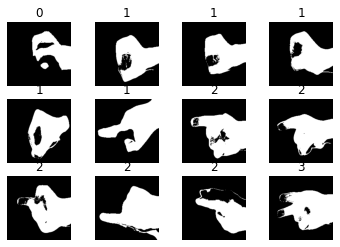

In [77]:
X_train_processed = preprocess_images(X_train)
for i in range(0, 12):
    plt.subplot(3,4,i+1)
    plt.imshow(X_train_processed[i], cmap='gray')
    plt.title(y_train[i+33])
    plt.axis('off')


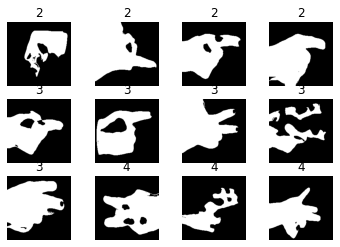

In [68]:
for i in range(0, 12):
    plt.subplot(3,4,i+1)
    plt.imshow(X_train_processed[i+33], cmap='gray')
    plt.title(y_train[i+40])
    plt.axis('off')

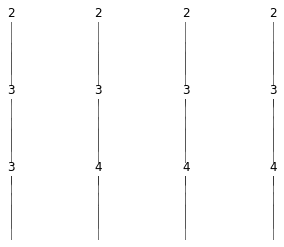

In [42]:
# Visualize the preprocessed images
#plot random 6 images from the training set




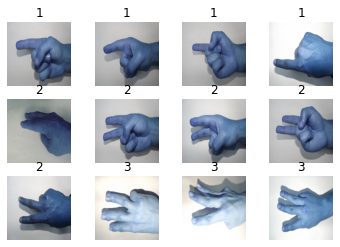

In [27]:
for i in range(0, 12):
    plt.subplot(3,4,i+1)
    plt.imshow(X_train[i+6], cmap='gray')
    plt.title(y_train[i+6])
    plt.axis('off')

In [13]:
# def extract_features(binary_img):
#     white_pixel_count = np.count_nonzero(binary_img)
#     return white_pixel_count

In [14]:
def extract_features(binary_img):
    height, width = binary_img.shape
    left_half_img = binary_img[:, :width//2]  # Extract the left half of the image
    white_pixel_count = np.count_nonzero(left_half_img)
    return white_pixel_count

In [15]:
training_features=np.zeros((X_train_processed.shape[0],1))

for i in range(training_features.shape[0]):
    training_features[i]=extract_features(X_train_processed[i])



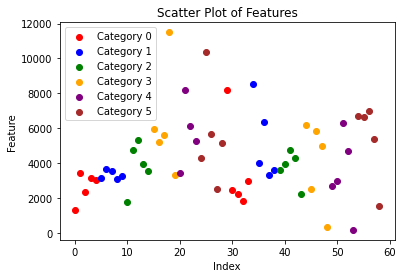

In [16]:
# Create an array of indices for each category
indices_0 = np.where(y_train == 0)[0]
indices_1 = np.where(y_train == 1)[0]
indices_2 = np.where(y_train == 2)[0]
indices_3 = np.where(y_train == 3)[0]
indices_4 = np.where(y_train == 4)[0]
indices_5 = np.where(y_train == 5)[0]

# Plot features with different colors for each category
plt.scatter(indices_0, training_features[indices_0], color='red', label='Category 0')
plt.scatter(indices_1, training_features[indices_1], color='blue', label='Category 1')
plt.scatter(indices_2, training_features[indices_2], color='green', label='Category 2')
plt.scatter(indices_3, training_features[indices_3], color='orange', label='Category 3')
plt.scatter(indices_4, training_features[indices_4], color='purple', label='Category 4')
plt.scatter(indices_5, training_features[indices_5], color='brown', label='Category 5')

plt.legend()  # Show legend
plt.xlabel('Index')
plt.ylabel('Feature')
plt.title('Scatter Plot of Features')

plt.show()

In [17]:
x_fit, x_test, y_fit, y_test = train_test_split(training_features, y_train, test_size=0.2, shuffle=True, stratify=labels)

# print(x_fit)
# print(x_test)
# print(y_fit)
# print(y_test)

clf = svm.SVC()

clf.fit(x_fit,y_fit)
y_predict = clf.predict(x_test)

score = accuracy_score(y_predict, y_test)

print('Accuracy: {} % '. format(score * 100))



Accuracy: 41.66666666666667 % 
